# CSE527 Homework 4
**Due date: 11:59 pm EST on Nov. 1, 2022 (Tue.)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 2,400 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

There are 2 problems in this homework with a total of 120 points including 20 bonus points. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/open?id=1NWC3TMsXSWN2TeoYMCjhf2N1b-WRDh-M) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.




In [ ]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Replace '------' with the path such that "Surname_Givenname_SBUID_hw*" is your working directory
%cd "/content/gdrive/My Drive/Chandramohanan_Ranjit_114856306_hw4"

/content/gdrive/My Drive/Chandramohanan_Ranjit_114856306_hw4


## Problem 0: Loading and Preprocessing data
---
(0 point) In this part, you are provided with a function that loads data into minibatches for training and testing in PyTorch. However, some preprocessing parts are missing. Your will need to implement them when doing Problem 1.

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------

def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

print(glob.glob('data/train/*'))
class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)

def load_dataset(path, img_size, num_per_class=-1, batch_size=16, shuffle=False,
           augment=False, is_color=False, zero_centered=False):    
    data = []
    labels = []    
    channel_num = 3 if is_color else 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img.astype(np.float)/255*2-1)
            
    ##########--WRITE YOUR CODE HERE--##########
    # Data Augmentation 
    if augment: 
        #left right flip
        for i in range(len(data)):
            data.append(np.flip(data[i],1))
            labels.append(labels[i])
    ##########-------END OF CODE-------##########    
    
    ##########--WRITE YOUR CODE HERE--##########
    # Data Normalization
    for i in range(len(data)):
        data[i] = (data[i] - cv2.meanStdDev(data[i])[0])
    ##########-------END OF CODE-------##########
         
    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_size > 1:
        batch_data = []
        batch_labels = []
         
        for i in range(int(len(data) / batch_size)):
            minibatch_d = data[i*batch_size: (i+1)*batch_size]
            minibatch_d = np.reshape(minibatch_d, (batch_size, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_size: (i+1)*batch_size]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

['data/train/Store', 'data/train/InsideCity', 'data/train/TallBuilding', 'data/train/OpenCountry', 'data/train/Office', 'data/train/Street', 'data/train/Mountain', 'data/train/Suburb', 'data/train/LivingRoom', 'data/train/Kitchen', 'data/train/Flower', 'data/train/Coast', 'data/train/Forest', 'data/train/Industrial', 'data/train/Highway', 'data/train/Bedroom']
class_names: {0: 'Store', 1: 'InsideCity', 2: 'TallBuilding', 3: 'OpenCountry', 4: 'Office', 5: 'Street', 6: 'Mountain', 7: 'Suburb', 8: 'LivingRoom', 9: 'Kitchen', 10: 'Flower', 11: 'Coast', 12: 'Forest', 13: 'Industrial', 14: 'Highway', 15: 'Bedroom'} 


In [ ]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 37 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

Bedroom


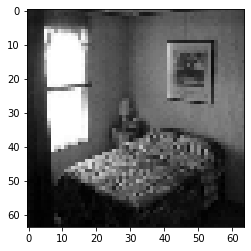

In [ ]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Problem 1: Training a Network From Scratch
The days of hand designed features are gone. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective function (in this case, 16-way classification accuracy). Let's start!

First, let's define a sample network architecture.

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()  
           
      self.features = torch.nn.Sequential(
        nn.Conv2d(1, 16, 3),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(4, stride=4), 
      )
      
      self.classifier = nn.Sequential(
         nn.Linear(3600, 16), 
      )
      
    def forward(self, x):
      x = self.features(x)  
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x  
  

Then, let's define model training and evaluation functions.

In [ ]:
#--------------------------------------------------
#       Model Training Function
#--------------------------------------------------
import torch.optim as optim
import time
  
def trainModel(net, trainloader, train_option, testloader=None):  
  loss_func = nn.CrossEntropyLoss()
  lr = train_option['lr']
  epoch = train_option['epoch']
  device = train_option['device'] if 'device' in train_option.keys() else 'cpu'
  log_iter = train_option['log_iter'] if 'log_iter' in train_option.keys() else 20
  eval_epoch = 1
  
  if 'optimizer' in train_option.keys():
    optimizer = train_option['optimizer']
  else:
    optimizer = optim.Adam(net.parameters(), lr=lr)

  start_time = time.time()
  if device == 'gpu':
    net = net.cuda()
    
  iters = 0
  running_loss = 0.0
  for ep in range(epoch):
    net.train()        
    for iter, (x, y) in enumerate(trainloader):
      iters += 1
      batch_x = Variable(x).float()
      batch_y = Variable(y).long()
      if device == 'gpu':
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()

      outputs = net(batch_x)
      loss = loss_func(outputs, batch_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      
      time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
      if iter % log_iter == 0:
        print('Epoch:{:2d} | Iter:{:5d} | Time: {} | Train Loss: {:.4f} | Average Loss: {:.4f} '.format(ep+1, iter, time_lapse, loss.item(), running_loss/iters))
   
    if testloader is not None and ep % eval_epoch == 0:
      evalModel(net, testloader)


In [ ]:
#--------------------------------------------------
#       Model Evaluating Function
#--------------------------------------------------
import time
  
def evalModel(net, testloader): 
  acc = 0.0
  count = 0
  start_time = time.time()
  device = 'gpu' if next(net.parameters()).is_cuda else 'cpu'
  net.eval()
  
  for iter, (x, y) in enumerate(testloader):
        count += x.shape[0]
        batch_x = Variable(x).float()
        batch_y = Variable(y).long()
        if device == 'gpu':
          batch_x = batch_x.cuda()
          batch_y = batch_y.cuda()
        outputs = net(batch_x)
        acc += torch.sum(outputs.max(1)[1]==batch_y)
        
  time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))        
  print('Accuracy: {:5f} | Time: {}'.format(acc/count,time_lapse))
  

Finally, let's start training and evaluation.

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet() 
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 20
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:03 | Train Loss: 2.7671 | Average Loss: 2.7671 
Epoch: 1 | Iter:   20 | Time: 00:00:03 | Train Loss: 2.5627 | Average Loss: 2.6738 
Accuracy: 0.395833 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:03 | Train Loss: 1.5985 | Average Loss: 2.4707 
Epoch: 2 | Iter:   20 | Time: 00:00:03 | Train Loss: 1.9254 | Average Loss: 2.2597 
Accuracy: 0.442708 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:03 | Train Loss: 1.2045 | Average Loss: 2.1329 
Epoch: 3 | Iter:   20 | Time: 00:00:03 | Train Loss: 1.4947 | Average Loss: 1.9891 
Accuracy: 0.458333 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:03 | Train Loss: 0.9593 | Average Loss: 1.8862 
Epoch: 4 | Iter:   20 | Time: 00:00:03 | Train Loss: 1.2075 | Average Loss: 1.7740 
Accuracy: 0.466146 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:03 | Train Loss: 0.8022 | Average Loss: 1.6892 
Epoch: 5 | Iter:   20 | Time: 00:00:03 | Train Loss: 0.9910 | Average Loss: 1.5972 
Accuracy: 0.4895

Great! You would get around 0.45-0.50 accuracy by this very simple network. Now it's your job to beat this result.

### Problem 1.1
(35 points) Try to boost the accuracy by doing the following steps:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you **left-right flip (mirror) an image** of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 2,400 original training images as much (because it sees 4,800 training images now, although they're not as good as 4,800 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't **zero-centered**. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. This part is **required**.

**Network Regularization**: Add **dropout layer**. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer (and try others if that helps). Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. In this part, you are **required** to add dropout layer to your network.

**Please give detailed descriptions of your network layout in the following format:**<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
**Then report the final accuracy on test set.**

The minimum accuracy required for this section is **0.55**.

In [ ]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 75 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()  
           
      self.features = torch.nn.Sequential(
        nn.Conv2d(1, 16, 3),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(4, stride=4), 
      )
      
      self.classifier = nn.Sequential(
         nn.Linear(3600, 16), 
      )
      self.dropout = nn.Dropout(0.5)
      
    def forward(self, x):
      x = self.features(x)  
      x = self.dropout(x)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x

#--------------------------------------------------

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet()
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 40
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8401 | Average Loss: 2.8401 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.7173 | Average Loss: 2.7025 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.3387 | Average Loss: 2.5180 
Epoch: 1 | Iter:   60 | Time: 00:00:00 | Train Loss: 1.8599 | Average Loss: 2.3912 
Accuracy: 0.408854 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.9616 | Average Loss: 2.3141 
Epoch: 2 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.0417 | Average Loss: 2.2085 
Epoch: 2 | Iter:   40 | Time: 00:00:00 | Train Loss: 1.9852 | Average Loss: 2.1434 
Epoch: 2 | Iter:   60 | Time: 00:00:00 | Train Loss: 1.5515 | Average Loss: 2.0912 
Accuracy: 0.468750 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.7145 | Average Loss: 2.0498 
Epoch: 3 | Iter:   20 | Time: 00:00:00 | Train Loss: 1.6992 | Average Loss: 1.9898 
Epoch: 3 | Iter:   40 | Time: 00:00:00 | Train Loss: 1.6850 | Average Loss: 1.9493 
Epoc

**Answer**:

Data augmentation: True (left-right flip)

Data normalization: True (subtracting mean to make the data zero-centered)

Layer 1: Convolutional layer: 1 input channels, 16 output channels, 3x3 kernel size, 1 stride with activation function ReLU with max pooling 2x2 kernel size, 2 stride

Layer 2: NN layer: 16x15x15 input nodes with dropout rate 0.5 and 16 output nodes

Accuray on test set: 0.6068 achieved at epoch 19


## Problem 1.2

(15 points) Try **three different techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

The minimum accuracy required for this section is **0.60**. (At least one Technique should achieve this)


### Technique 1

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))



Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 75 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()  
           
      self.features = torch.nn.Sequential(
        nn.Conv2d(1, 64, 5),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4), 
        nn.Conv2d(64, 128, 4),
        nn.Sigmoid(),
        nn.MaxPool2d(4, stride=4), 
      )
      
      self.classifier = nn.Sequential(
          nn.Linear(128*3*3, 16),
      )
      self.dropout = nn.Dropout(0.5)
      
    def forward(self, x):
      x = self.features(x)  
      x = self.dropout(x)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x
          

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet() 
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 40
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8445 | Average Loss: 2.8445 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.6932 | Average Loss: 2.8294 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.5117 | Average Loss: 2.7217 
Epoch: 1 | Iter:   60 | Time: 00:00:00 | Train Loss: 2.2002 | Average Loss: 2.6044 
Accuracy: 0.296875 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.2718 | Average Loss: 2.5215 
Epoch: 2 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.0648 | Average Loss: 2.4320 
Epoch: 2 | Iter:   40 | Time: 00:00:01 | Train Loss: 1.9228 | Average Loss: 2.3650 
Epoch: 2 | Iter:   60 | Time: 00:00:01 | Train Loss: 1.6851 | Average Loss: 2.2852 
Accuracy: 0.432292 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:01 | Train Loss: 1.9295 | Average Loss: 2.2328 
Epoch: 3 | Iter:   20 | Time: 00:00:01 | Train Loss: 1.7881 | Average Loss: 2.1759 
Epoch: 3 | Iter:   40 | Time: 00:00:01 | Train Loss: 1.6042 | Average Loss: 2.1248 
Epoc

**Answer**:

Technique 1: Changing the architecture of the network by adding one more convolutional layer and changing the activation functions

Layer 1: Convolutional layer: 1 input channels, 64 output channels, 5x5 kernel size, 1 stride with activation function ReLU with max pooling 4x4 kernel size, 4 stride

Layer 2: Convolutional layer: 64 input channels, 128 output channels, 4x4 kernel size, 1 stride with activation function Sigmoid with max pooling 4x4 kernel size, 4 stride

Layer 3: NN layer: 128*3*3 input nodes with dropout rate 0.5 and 16 output nodes

Accuracy on test set: **0.7552** at epoch 37

Accuracy increases/decreases: Accuracy increases by **0.1484**

### Technique 2

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))


Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 75 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()  
           
      self.features = torch.nn.Sequential(
        nn.Conv2d(1, 64, 5),       
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(4, stride=4), 
        nn.Conv2d(64, 128, 4),
        nn.Sigmoid(),
        nn.MaxPool2d(4, stride=4), 
      )
      
      self.classifier = nn.Sequential(
          nn.Linear(128*3*3, 288),
          nn.ReLU(inplace=True),
          nn.BatchNorm1d(288),
          nn.Dropout(0.5),
          nn.Linear(288, 16),
      )
      self.dropout = nn.Dropout(0.25)
      
    def forward(self, x):
      x = self.features(x)  
      x = self.dropout(x)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet()
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 40
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.1094 | Average Loss: 3.1094 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.2769 | Average Loss: 2.5257 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.0505 | Average Loss: 2.3153 
Epoch: 1 | Iter:   60 | Time: 00:00:00 | Train Loss: 1.7216 | Average Loss: 2.1740 
Accuracy: 0.510417 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.7086 | Average Loss: 2.0940 
Epoch: 2 | Iter:   20 | Time: 00:00:01 | Train Loss: 1.5726 | Average Loss: 1.9920 
Epoch: 2 | Iter:   40 | Time: 00:00:01 | Train Loss: 1.3259 | Average Loss: 1.8948 
Epoch: 2 | Iter:   60 | Time: 00:00:01 | Train Loss: 1.3265 | Average Loss: 1.8126 
Accuracy: 0.630208 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:01 | Train Loss: 1.3150 | Average Loss: 1.7629 
Epoch: 3 | Iter:   20 | Time: 00:00:01 | Train Loss: 1.2699 | Average Loss: 1.7077 
Epoch: 3 | Iter:   40 | Time: 00:00:02 | Train Loss: 1.2418 | Average Loss: 1.6497 
Epoc

**Answer**:

Technique 2: Similar to technique 1 with addition to adding batch normalization and adding another fully connected layer 

Layer 1: Convolutional layer: 1 input channels, 64 output channels, 5x5 kernel size, 1 stride activation function ReLU with max pooling 4x4 kernel size, 4 stride

Layer 2: Convolutional layer: 64 input channels, 128 output channels, 4x4 kernel size, 1 stride with activation function Sigmoid with max pooling 4x4 kernel size, 4 stride

Layer 3: NN layer: 128x3x3 input nodes with dropout rate 0.25 and 288 output nodes with batch normalization and activation function ReLU

Layer 4: NN layer: 288 input nodes with dropout rate 0.5 and 16 output nodes

Accuracy on test set: **0.7656** at epoch 21

Accuracy increases/decreases: Accuracy increases by **0.1588**

### Technique 3

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 75 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()  
           
      self.features = torch.nn.Sequential(
        nn.Conv2d(1, 64, 5),
        nn.Tanh(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(3, stride=3), 
        nn.Conv2d(64, 128, 4),
        nn.Sigmoid(),
        nn.MaxPool2d(4, stride=4), 
      )
      
      self.classifier = nn.Sequential(
          nn.Linear(128 * 4 * 4, 512),
          nn.LeakyReLU(inplace=True),
          nn.BatchNorm1d(512),
          nn.Dropout(0.5),
          nn.Linear(512, 16),
      )
      self.dropout = nn.Dropout(0.25)
      
    def forward(self, x):
      x = self.features(x)  
      x = self.dropout(x)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x


In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet()
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 40
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.0774 | Average Loss: 3.0774 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.5430 | Average Loss: 2.5486 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 1.9307 | Average Loss: 2.3698 
Epoch: 1 | Iter:   60 | Time: 00:00:01 | Train Loss: 1.8228 | Average Loss: 2.2123 
Accuracy: 0.421875 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:01 | Train Loss: 1.8667 | Average Loss: 2.1397 
Epoch: 2 | Iter:   20 | Time: 00:00:01 | Train Loss: 1.6603 | Average Loss: 2.0275 
Epoch: 2 | Iter:   40 | Time: 00:00:01 | Train Loss: 1.5128 | Average Loss: 1.9461 
Epoch: 2 | Iter:   60 | Time: 00:00:02 | Train Loss: 1.4699 | Average Loss: 1.8722 
Accuracy: 0.625000 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:02 | Train Loss: 1.5436 | Average Loss: 1.8192 
Epoch: 3 | Iter:   20 | Time: 00:00:02 | Train Loss: 1.1060 | Average Loss: 1.7495 
Epoch: 3 | Iter:   40 | Time: 00:00:02 | Train Loss: 1.0822 | Average Loss: 1.6974 
Epoc

**Answer**:

Technique 3: Making use of Tanh activation function during convolutional layers and Leaky ReLU activation function during fully connected layers

Layer 1: Convolutional layer: 1 input channels, 64 output channels, 5x5 kernel size, 1 stride activation function Tanh with max pooling 3x3 kernel size, 3 stride

Layer 2: Convolutional layer: 64 input channels, 128 output channels, 4x4 kernel size, 1 stride with activation function Sigmoid with max pooling 4x4 kernel size, 4 stride

Layer 3: NN layer: 128x4x4 input nodes with dropout rate 0.25 and 128 output nodes with batch normalization and activation function Leaky ReLU

Layer 4: NN layer: 1024 input nodes with dropout rate 0.5 and 16 output nodes

Accuracy on test set: **0.7473** at epoch 26

Accuracy increases/decreases: Accuracy increases by **0.1405**

## Problem 2: Fine Tuning a Pre-Trained Deep Network
Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.


**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

### Problem 2.1

**Strategy A**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 16 classes) this is an attractive option. Fine-tuning can work far better than Strategy B of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

(25 points) You are required to implement Strategy A to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve accuracy of **0.85** approximately. The minimum accuracy required for this section is **0.75**.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set <br>

In [ ]:
# reload data with a larger size
img_size = (224, 224)
batch_size = 64 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, 
                                      augment=False, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_large = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, is_color=True, zero_centered=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 37 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

In [ ]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------
import torchvision.models as models

net = models.alexnet(pretrained=True)

print(net)



/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
from torch.nn.modules.dropout import Dropout
class Identity(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x

class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()  
           
      self.classifier = nn.Sequential(
        nn.Linear(9216, 1024),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(1024),
        nn.Dropout(0.25),
        nn.Linear(1024, 1024),
        nn.LeakyReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(1024, 16),
      )

      self.dropout = nn.Dropout(0.25)

    
    def forward(self, x):
      x = self.dropout(x)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x

net.avgpool = Identity()
net.classifier = TNet()

In [ ]:
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 20
train_option['device'] = 'gpu'
train_option['optimizer'] = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
trainModel(net, trainloader_large, train_option, testloader_large)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8120 | Average Loss: 2.8120 
Epoch: 1 | Iter:   20 | Time: 00:00:02 | Train Loss: 2.1552 | Average Loss: 2.5255 
Accuracy: 0.776042 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:03 | Train Loss: 1.5452 | Average Loss: 2.1663 
Epoch: 2 | Iter:   20 | Time: 00:00:05 | Train Loss: 0.9918 | Average Loss: 1.8101 
Accuracy: 0.841146 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:07 | Train Loss: 0.8628 | Average Loss: 1.5895 
Epoch: 3 | Iter:   20 | Time: 00:00:08 | Train Loss: 0.5832 | Average Loss: 1.3922 
Accuracy: 0.848958 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:10 | Train Loss: 0.5787 | Average Loss: 1.2634 
Epoch: 4 | Iter:   20 | Time: 00:00:12 | Train Loss: 0.3873 | Average Loss: 1.1411 
Accuracy: 0.864583 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:14 | Train Loss: 0.4403 | Average Loss: 1.0567 
Epoch: 5 | Iter:   20 | Time: 00:00:15 | Train Loss: 0.2699 | Average Loss: 0.9728 
Accuracy: 0.8750

**Answer**:

(1) which layers of AlexNet have been replaced: The classifier layer has been modified by adding batch normalization and changing the output nodes to 16

(2) the architecture of the new layers added including activation methods (same as problem 1)

Layer 1: NN layer: 9216 input nodes with dropout rate 0.25 and 1024 output nodes with batch normalization and activation function ReLU

Layer 2: NN layer: 1024 input nodes with dropout rate 0.25 and 1024 output nodes with activation function LeakyReLU

Layer 3: NN layer: 1024 input nodes with dropout rate 0.5 and 16 output nodes

Data augmentation: Did not augment the data

Data normalization: True (subtracting mean to make the data zero-centered)

Features Layers : The features layers are not modified

Accuracy on test set: **0.8958** at epoch 14

### Problem 2.2
**Strategy B**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 1000 activations.

(25 points) Implement Strategy B where you use the activations of the pre-trained **AlexNet** as features to train **one-vs-all SVMs** for your scene classification task. Report the final accuracy on test set. You should be able to achieve accuracy of **0.80** approximately. The minimum accuracy required for this section is **0.70**.

In [ ]:
#--------------------------------------------------
#       Get Features from AlexNet
#--------------------------------------------------
net = models.alexnet(pretrained=True)

net = net.cuda()

def get_features(net, dataloader):
    features = []
    labels = []
    for i, (x,y) in enumerate(dataloader):
        batch_x = Variable(x).float().cuda()
        batch_y = Variable(y).float().cuda()
        outputs = net(batch_x)
        features.append(outputs.data.cpu().numpy())
        labels.append(batch_y.data.cpu().numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

train_feat, train_label = get_features(net, trainloader_large)
test_feat, test_label = get_features(net, testloader_large)

In [ ]:
print(train_feat.shape)
print(test_feat.shape)
print(train_label.shape)
print(test_label.shape)

(2368, 1000)
(384, 1000)
(2368,)
(384,)


In [ ]:
#--------------------------------------------------
#       Train and Evaluate SVM
#--------------------------------------------------
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

def train(X, Y):
    model = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
    model.fit(X, Y)
    return model

def predict(model, x):
    predict = model.predict(x)
    return predict

model = train(train_feat, train_label)

predictions = [-1]*len(test_feat)
for i in range(len(test_feat)):
    predictions[i] = predict(model, test_feat[i].reshape(1,-1))

predictions = np.array(predictions)

accuracy = accuracy_score(test_label, predictions)
print("The accuracy of one-vs-all SVMs model is {:.2f}%".format(accuracy*100))

The accuracy of one-vs-all SVMs model is 77.86%


**Answer**:

Accuracy on test set: **77.6%**

### Problem 2.3 (Bonus)

(Bonus: 10 points) Bonus will be given to those who fine-tune the [ResNet network](https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html) [(paper)](https://arxiv.org/abs/1512.03385) and compare performance with AlexNet. Explain why ResNet performed better or worse. You are **required** to use **resnet50** model. You should be able to achieve accuracy of **0.99** approximately. The minimum accuracy required for this section is **0.85**.

In [ ]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------
net = models.resnet50(pretrained=True)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
net.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.LeakyReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 16),
)

train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 20
train_option['device'] = 'gpu'
train_option['optimizer'] = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
trainModel(net, trainloader_large, train_option, testloader_large)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.7988 | Average Loss: 2.7988 
Epoch: 1 | Iter:   20 | Time: 00:00:16 | Train Loss: 1.4742 | Average Loss: 2.2501 
Accuracy: 0.822917 | Time: 00:00:01
Epoch: 2 | Iter:    0 | Time: 00:00:30 | Train Loss: 0.5586 | Average Loss: 1.5982 
Epoch: 2 | Iter:   20 | Time: 00:00:45 | Train Loss: 0.3019 | Average Loss: 1.1723 
Accuracy: 0.890625 | Time: 00:00:01
Epoch: 3 | Iter:    0 | Time: 00:01:00 | Train Loss: 0.1872 | Average Loss: 0.9678 
Epoch: 3 | Iter:   20 | Time: 00:01:15 | Train Loss: 0.1001 | Average Loss: 0.7919 
Accuracy: 0.820312 | Time: 00:00:01
Epoch: 4 | Iter:    0 | Time: 00:01:29 | Train Loss: 0.0814 | Average Loss: 0.6842 
Epoch: 4 | Iter:   20 | Time: 00:01:44 | Train Loss: 0.0142 | Average Loss: 0.5883 
Accuracy: 0.898438 | Time: 00:00:01
Epoch: 5 | Iter:    0 | Time: 00:01:59 | Train Loss: 0.0310 | Average Loss: 0.5255 
Epoch: 5 | Iter:   20 | Time: 00:02:14 | Train Loss: 0.0257 | Average Loss: 0.4657 
Accuracy: 0.9218

**Answer**:

Accuracy on test set: **0.9505** at epoch 20

Resnet50 performed better than AlexNet because it has more layers and more parameters along with using batch normalization to its architecture. It is also able to learn more complex features from the data because of the residual connections. The residual connections help in learning the features from the data without losing the information from the previous layers. It also solves the vanishing gradient problem.


## Submission guidelines
---
We will grade your homework based on your submitted notebook file. We will check the notebook for both results and code. Please make sure you run your code and print out the results in the notebook before submitting (we expect to see the results before running your code by ourselves.)

You submit your homework by first creating a ***google shared link*** of a folder for your homework (described below), and put that link into the ***text submission section*** of your homework submission on Blackboard. ([How to submit your link?](https://drive.google.com/file/d/16-FlPSiu5n-pRezLfcbAvgYxXtGtrs16))

To generate the ***google shared link***, first create a folder named ***Surname_Givenname_SBUID_hw**** in your Google Drive with your CS account (or your SBU account if you don't have a CS account). The structure of the files in the folder should be exactly the same as the one you downloaded. For instance in this homework:

```
Surname_Givenname_SBUID_hw4
        |---CSE527-22F-HW4.ipynb
```
Note that this folder should be in your Google Drive with your account.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter the TAs' email: ***haoyuwu@cs.stonybrook.edu*** and ***vhnguyen@cs.stonybrook.edu***. Make sure that the TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box. ([How to share link?](https://drive.google.com/file/d/17R6j6yE8_8vXioOB3nNvbEPzxcI-rr_H) )

***IMPORTANT: Please do not make any modification to the folder and its files after the submission deadline***. (All modifications can be seen by the TAs via the revision history.) Note that in google colab, we will only grade the version of the code right before the timestamp of the submission made in blackboard.

The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw1' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs.


-- DO NOT change the folder structure, please just fill in the blanks. <br>

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be delays in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.


<!--Write your report here in markdown or html-->
